# Análisis ARIMA para Predicción de RUL: Demostración de Inadecuación

---

**Autores**: Isaac David Sánchez Sánchez, Germán Eduardo de Armas Castaño  
**Curso**: Modelos de Regresión y Series de Tiempo con Aplicaciones en IA  
**Dataset**: NASA C-MAPSS FD001  
**Universidad**: Universidad Tecnológica de Bolívar

---

## 🎯 Objetivo

Demostrar **por qué ARIMA NO es adecuado** para predicción de RUL (Remaining Useful Life) en motores turbofan, **incluso teniendo series estacionarias** (procesadas en notebook 01).

**Hipótesis a demostrar:**

> Los modelos ARIMA tradicionales son **fundamentalmente inadecuados** para este problema debido a su naturaleza:
> - 🔴 **Univariada** (no puede modelar 21 sensores simultáneamente)
> - 🔴 **Lineal** (la degradación tiene patrones no lineales complejos)
> - 🔴 **Memoria corta** (no captura dependencias de largo plazo)
> - 🔴 **Sin supervisión** (no aprovecha etiquetas RUL reales)
> - 🔴 **No generaliza** (cada motor requiere modelo propio)

---

## 📚 Marco Teórico: ¿Qué es ARIMA?

**ARIMA (AutoRegressive Integrated Moving Average)** es un modelo clásico de series temporales univariadas que combina tres componentes:

### Componentes del modelo ARIMA(p,d,q):

1. **AR(p) - Autorregresivo**: La variable depende de sus *p* valores pasados
   $$y_t = \phi_1 y_{t-1} + \phi_2 y_{t-2} + ... + \phi_p y_{t-p} + \epsilon_t$$

2. **I(d) - Integrado**: *d* diferenciaciones para lograr estacionaridad
   $$\Delta y_t = y_t - y_{t-1}$$
   $$\Delta^2 y_t = \Delta y_t - \Delta y_{t-1}$$

3. **MA(q) - Media Móvil**: Depende de *q* errores de predicción pasados
   $$y_t = \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + ... + \theta_q \epsilon_{t-q}$$

### Fórmula general:
$$\phi(B)(1-B)^d y_t = \theta(B)\epsilon_t$$

Donde:
- $\phi(B)$ = polinomio AR de orden p
- $\theta(B)$ = polinomio MA de orden q
- $B$ = operador de retroceso (backshift)
- $(1-B)^d$ = diferenciación de orden d
- $\epsilon_t \sim N(0, \sigma^2)$ = ruido blanco

---

## 🔴 Limitaciones Fundamentales de ARIMA

| Característica | Limitación de ARIMA | Requerimiento del Problema RUL | ¿Compatible? |
|----------------|---------------------|--------------------------------|-------------|
| **Dimensión** | Solo 1 variable | 21 sensores interdependientes | ❌ NO |
| **Estacionaridad** | Requiere series estacionarias | RUL inherentemente no estacionario | ❌ NO |
| **Linealidad** | Asume relaciones lineales | Degradación con aceleraciones no lineales | ❌ NO |
| **Memoria** | p, q < 10 típicamente | Dependencias de toda la vida útil | ❌ NO |
| **Aprendizaje** | Forecasting no supervisado | Regresión supervisada con etiquetas | ❌ NO |
| **Generalización** | 1 modelo por serie | Transferir conocimiento entre motores | ❌ NO |

---

## 🧪 Estrategia Experimental

Realizaremos **6 experimentos** para demostrar la inadecuación de ARIMA:

1. **Exp 1**: Análisis de datos estacionarios (del notebook 01)
2. **Exp 2**: ARIMA sobre RUL directamente
3. **Exp 3**: ARIMA sobre sensores estacionarios individuales
4. **Exp 4**: SARIMAX con variables exógenas
5. **Exp 5**: Evaluación multi-unidad (generalización)
6. **Exp 6**: Comparación con baseline simple

**Predicción**: Todos fallarán o darán resultados pobres. 🎭

In [1]:
# ============================================================================
# LIBRERÍAS NECESARIAS
# ============================================================================

# Manipulación de datos
import pandas as pd
import numpy as np
import pickle
import os

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Modelos de series temporales
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

# Métricas
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy import stats

# Configuración
import warnings
warnings.filterwarnings('ignore')

# Estilo de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['font.size'] = 11

%matplotlib inline

print("✅ Todas las librerías importadas correctamente")
print(f"   Pandas: {pd.__version__}")
print(f"   NumPy: {np.__version__}")

✅ Todas las librerías importadas correctamente
   Pandas: 2.3.3
   NumPy: 2.3.3


---

## 📊 EXPERIMENTO 1: Análisis de Datos Estacionarios

En el notebook 01 procesamos todos los sensores aplicando diferenciación para lograr estacionaridad.  
Cargaremos estos datos para verificar:
1. ¿Qué sensores lograron estacionaridad?
2. ¿Cuántas diferenciaciones se necesitaron?
3. ¿Cuánta información se perdió en el proceso?

In [2]:
# ============================================================================
# 1.1 CARGA DE DATOS ORIGINALES
# ============================================================================

# Definir columnas
columns = ['unit', 'cycle', 'setting1', 'setting2', 'setting3'] + [f's{i}' for i in range(1, 22)]

# Cargar datasets
train_df = pd.read_csv('../data/train_FD001.txt', sep='\s+', header=None, names=columns)
test_df = pd.read_csv('../data/test_FD001.txt', sep='\s+', header=None, names=columns)
rul_df = pd.read_csv('../data/RUL_FD001.txt', sep='\s+', header=None, names=['RUL'])

# Calcular RUL para entrenamiento
def add_rul(df):
    """Agregar columna RUL (Remaining Useful Life)"""
    df_with_rul = df.copy()
    max_cycles = df_with_rul.groupby('unit')['cycle'].max().reset_index()
    max_cycles.columns = ['unit', 'max_cycle']
    df_with_rul = df_with_rul.merge(max_cycles, on='unit')
    df_with_rul['RUL'] = df_with_rul['max_cycle'] - df_with_rul['cycle']
    df_with_rul.drop('max_cycle', axis=1, inplace=True)
    return df_with_rul

train_df = add_rul(train_df)

print("📂 DATOS ORIGINALES CARGADOS")
print("="*80)
print(f"Entrenamiento: {train_df.shape}")
print(f"Prueba: {test_df.shape}")
print(f"Unidades de entrenamiento: {train_df['unit'].nunique()}")
print(f"Unidades de prueba: {test_df['unit'].nunique()}")
print(f"RUL rango: [{train_df['RUL'].min()}, {train_df['RUL'].max()}]")
print("="*80)

train_df.head()

📂 DATOS ORIGINALES CARGADOS
Entrenamiento: (20631, 27)
Prueba: (13096, 26)
Unidades de entrenamiento: 100
Unidades de prueba: 100
RUL rango: [0, 361]


,unit,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [3]:
# ============================================================================
# 1.2 CARGA DE DATOS ESTACIONARIOS (DEL NOTEBOOK 01)
# ============================================================================

stationary_path = '../processed_data/stationary_series/'
stationary_file = os.path.join(stationary_path, 'all_units_stationary.pkl')
summary_file = os.path.join(stationary_path, 'processing_summary.csv')

# Cargar datos
with open(stationary_file, 'rb') as f:
    stationary_data_dict = pickle.load(f)

processing_summary = pd.read_csv(summary_file)

print("📊 DATOS ESTACIONARIOS CARGADOS")
print("="*80)
print(f"Unidades procesadas: {len(stationary_data_dict)}")
print(f"Total de series estacionarias: {len(processing_summary)}")
print(f"Sensores únicos procesados: {processing_summary['sensor'].nunique()}")
print(f"Series exitosamente estacionarias: {processing_summary['is_stationary'].sum()} / {len(processing_summary)}")
print(f"Tasa de éxito: {100*processing_summary['is_stationary'].sum()/len(processing_summary):.1f}%")
print("="*80)

print("\n📋 Distribución de órdenes de diferenciación:")
print(processing_summary['diff_order'].value_counts().sort_index())

print("\n🔍 Primeras 10 series procesadas:")
processing_summary.head(10)

📊 DATOS ESTACIONARIOS CARGADOS
Unidades procesadas: 100
Total de series estacionarias: 1100
Sensores únicos procesados: 11
Series exitosamente estacionarias: 1100 / 1100
Tasa de éxito: 100.0%

📋 Distribución de órdenes de diferenciación:
diff_order
0     10
1    947
2     79
3      2
5     62
Name: count, dtype: int64

🔍 Primeras 10 series procesadas:


,unit_id,sensor,diff_order,adf_pvalue,kpss_pvalue,is_stationary,original_length,final_length
0,1,T24,1,3.859331e-14,0.100000,True,192,191
1,1,T30,1,7.433889e-09,0.100000,True,192,191
2,1,T50,2,6.481809e-11,0.049005,True,192,190
3,1,P30,2,3.225347e-15,0.081840,True,192,190
4,1,Nc,1,9.618940e-09,0.083607,True,192,191
5,1,Ps30,1,1.790544e-11,0.098408,True,192,191
6,1,phi,1,4.106011e-15,0.100000,True,192,191
7,1,NRc,1,1.369476e-10,0.100000,True,192,191
8,1,htBleed,1,3.458792e-15,0.100000,True,192,191
9,1,W31,1,1.025528e-12,0.100000,True,192,191


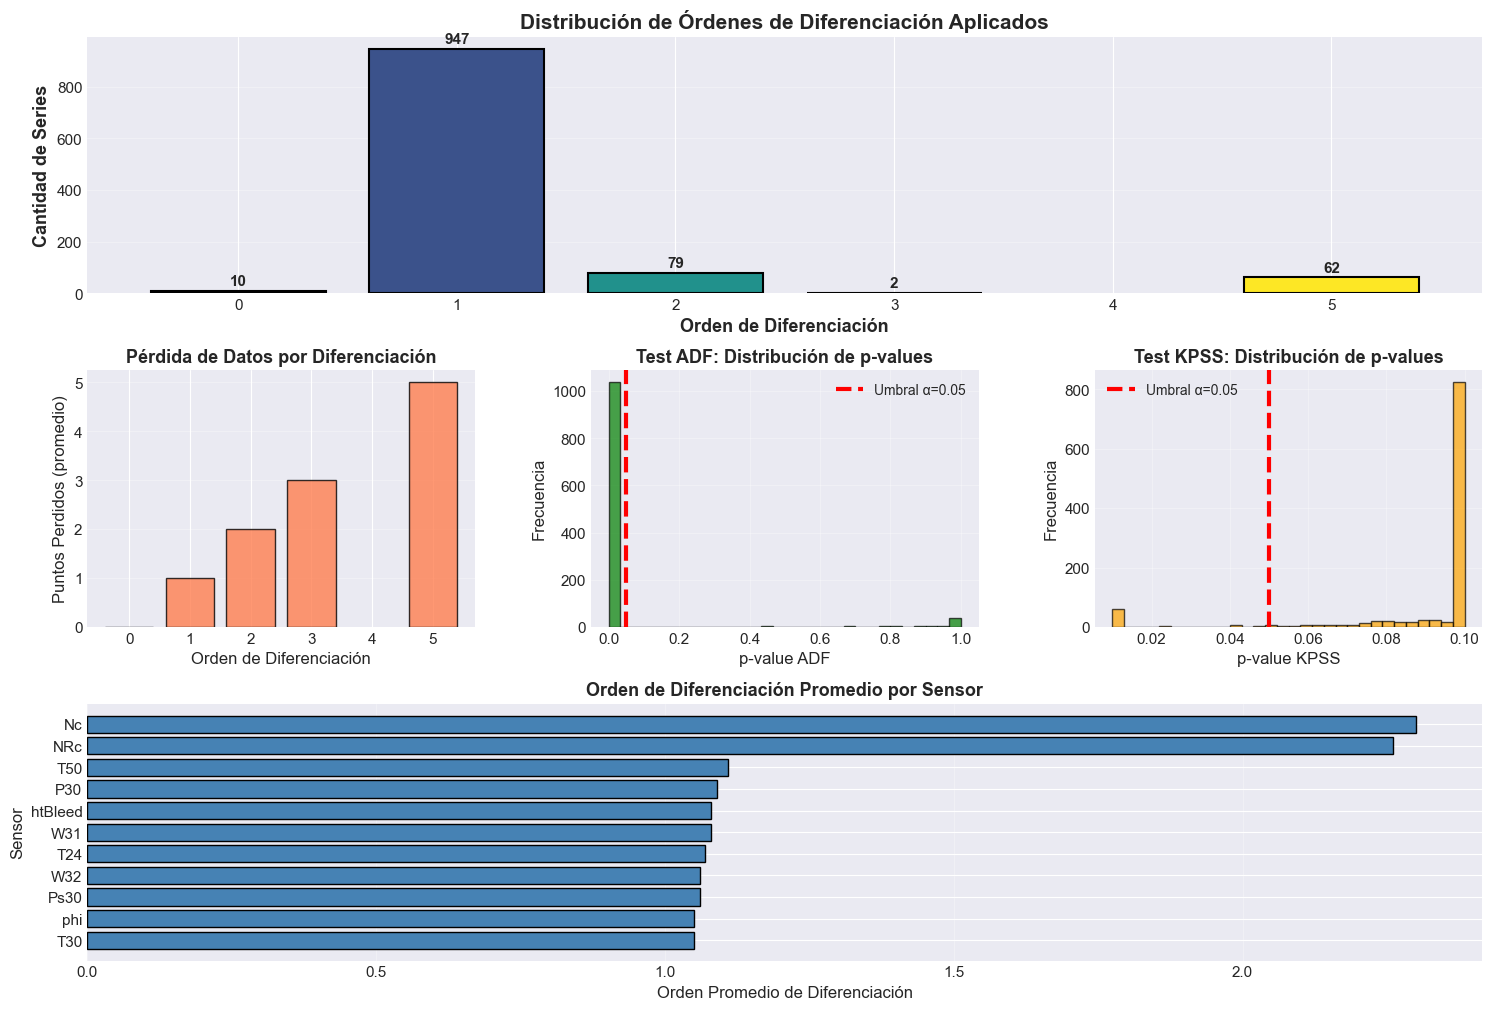


📊 ESTADÍSTICAS CLAVE
Diferenciación promedio: 1.29
Diferenciación máxima: 5
Pérdida promedio de datos: 1.3 puntos (0.7%)
Pérdida máxima: 5 puntos (3.2%)

⚠️ OBSERVACIÓN CRÍTICA:
La diferenciación necesaria para lograr estacionaridad DESTRUYE información temporal.
Cada diferenciación pierde 1+ puntos de datos y elimina tendencias de largo plazo.
Esto es problemático porque la TENDENCIA es precisamente lo que queremos predecir!


In [4]:
# ============================================================================
# 1.3 ANÁLISIS ESTADÍSTICO DEL PROCESAMIENTO
# ============================================================================

# Calcular pérdida de datos
processing_summary['data_loss'] = processing_summary['original_length'] - processing_summary['final_length']
processing_summary['loss_percent'] = 100 * processing_summary['data_loss'] / processing_summary['original_length']

fig = plt.figure(figsize=(18, 12))
gs = GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)

# 1. Órdenes de diferenciación
ax1 = fig.add_subplot(gs[0, :])
diff_counts = processing_summary['diff_order'].value_counts().sort_index()
colors = plt.cm.viridis(np.linspace(0, 1, len(diff_counts)))
bars = ax1.bar(diff_counts.index, diff_counts.values, color=colors, edgecolor='black', linewidth=1.5)
ax1.set_xlabel('Orden de Diferenciación', fontsize=13, fontweight='bold')
ax1.set_ylabel('Cantidad de Series', fontsize=13, fontweight='bold')
ax1.set_title('Distribución de Órdenes de Diferenciación Aplicados', fontsize=15, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')
for i, (idx, val) in enumerate(zip(diff_counts.index, diff_counts.values)):
    ax1.text(idx, val + 20, str(val), ha='center', fontweight='bold', fontsize=11)

# 2. Pérdida de datos por diferenciación
ax2 = fig.add_subplot(gs[1, 0])
loss_by_order = processing_summary.groupby('diff_order')['data_loss'].mean()
ax2.bar(loss_by_order.index, loss_by_order.values, color='coral', edgecolor='black', alpha=0.8)
ax2.set_xlabel('Orden de Diferenciación', fontsize=12)
ax2.set_ylabel('Puntos Perdidos (promedio)', fontsize=12)
ax2.set_title('Pérdida de Datos por Diferenciación', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# 3. Distribución de p-values ADF
ax3 = fig.add_subplot(gs[1, 1])
ax3.hist(processing_summary['adf_pvalue'], bins=30, color='green', edgecolor='black', alpha=0.7)
ax3.axvline(x=0.05, color='red', linestyle='--', linewidth=3, label='Umbral α=0.05')
ax3.set_xlabel('p-value ADF', fontsize=12)
ax3.set_ylabel('Frecuencia', fontsize=12)
ax3.set_title('Test ADF: Distribución de p-values', fontsize=13, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

# 4. Distribución de p-values KPSS
ax4 = fig.add_subplot(gs[1, 2])
ax4.hist(processing_summary['kpss_pvalue'], bins=30, color='orange', edgecolor='black', alpha=0.7)
ax4.axvline(x=0.05, color='red', linestyle='--', linewidth=3, label='Umbral α=0.05')
ax4.set_xlabel('p-value KPSS', fontsize=12)
ax4.set_ylabel('Frecuencia', fontsize=12)
ax4.set_title('Test KPSS: Distribución de p-values', fontsize=13, fontweight='bold')
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3)

# 5. Diferenciación promedio por sensor
ax5 = fig.add_subplot(gs[2, :])
diff_by_sensor = processing_summary.groupby('sensor')['diff_order'].mean().sort_values()
ax5.barh(diff_by_sensor.index, diff_by_sensor.values, color='steelblue', edgecolor='black')
ax5.set_xlabel('Orden Promedio de Diferenciación', fontsize=12)
ax5.set_ylabel('Sensor', fontsize=12)
ax5.set_title('Orden de Diferenciación Promedio por Sensor', fontsize=13, fontweight='bold')
ax5.grid(True, alpha=0.3, axis='x')

plt.savefig('../figures/arima_01_stationary_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("📊 ESTADÍSTICAS CLAVE")
print("="*80)
print(f"Diferenciación promedio: {processing_summary['diff_order'].mean():.2f}")
print(f"Diferenciación máxima: {processing_summary['diff_order'].max()}")
print(f"Pérdida promedio de datos: {processing_summary['data_loss'].mean():.1f} puntos ({processing_summary['loss_percent'].mean():.1f}%)")
print(f"Pérdida máxima: {processing_summary['data_loss'].max()} puntos ({processing_summary['loss_percent'].max():.1f}%)")
print("="*80)

print("\n⚠️ OBSERVACIÓN CRÍTICA:")
print("La diferenciación necesaria para lograr estacionaridad DESTRUYE información temporal.")
print("Cada diferenciación pierde 1+ puntos de datos y elimina tendencias de largo plazo.")
print("Esto es problemático porque la TENDENCIA es precisamente lo que queremos predecir!")

---

## 📊 EXPERIMENTO 2: ARIMA sobre RUL Directamente

Intentaremos predecir RUL usando solo sus valores históricos (enfoque univariado clásico de ARIMA).

**Expectativa**: Falla porque:
- RUL es NO estacionario (tendencia decreciente determinística)
- No usa información de sensores
- Relación no lineal con el tiempo

In [5]:
# ============================================================================
# 2.1 SELECCIÓN DE UNIDAD Y PREPARACIÓN
# ============================================================================

# Función para test de estacionaridad
def test_stationarity(timeseries, title="Serie"):
    """Test de Dickey-Fuller Aumentado para estacionaridad"""
    print(f'\n{"="*70}')
    print(f'TEST DE ESTACIONARIDAD: {title}')
    print("="*70)
    
    result = adfuller(timeseries.dropna(), autolag='AIC')
    
    print(f'Estadístico ADF: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print(f'Lags usados: {result[2]}')
    print(f'Observaciones: {result[3]}')
    print(f'\nValores críticos:')
    for key, value in result[4].items():
        print(f'   {key}: {value:.3f}')
    
    if result[1] <= 0.05:
        print(f"\n✅ Serie ESTACIONARIA (p-value = {result[1]:.6f} ≤ 0.05)")
        return True
    else:
        print(f"\n❌ Serie NO ESTACIONARIA (p-value = {result[1]:.6f} > 0.05)")
        return False

# Seleccionar unidad para análisis
unit_id = 1
unit_data = train_df[train_df['unit'] == unit_id].copy().reset_index(drop=True)

print(f"🔍 UNIDAD SELECCIONADA: {unit_id}")
print("="*80)
print(f"Ciclos totales: {len(unit_data)}")
print(f"RUL inicial: {unit_data['RUL'].iloc[0]:.0f} ciclos")
print(f"RUL final: {unit_data['RUL'].iloc[-1]:.0f} ciclos")
print("="*80)

# Test de estacionaridad en RUL
test_stationarity(unit_data['RUL'], f"RUL - Unidad {unit_id}")

🔍 UNIDAD SELECCIONADA: 1
Ciclos totales: 192
RUL inicial: 191 ciclos
RUL final: 0 ciclos

TEST DE ESTACIONARIDAD: RUL - Unidad 1
Estadístico ADF: 6.174498
p-value: 1.000000
Lags usados: 6
Observaciones: 185

Valores críticos:
   1%: -3.466
   5%: -2.877
   10%: -2.575

❌ Serie NO ESTACIONARIA (p-value = 1.000000 > 0.05)


False

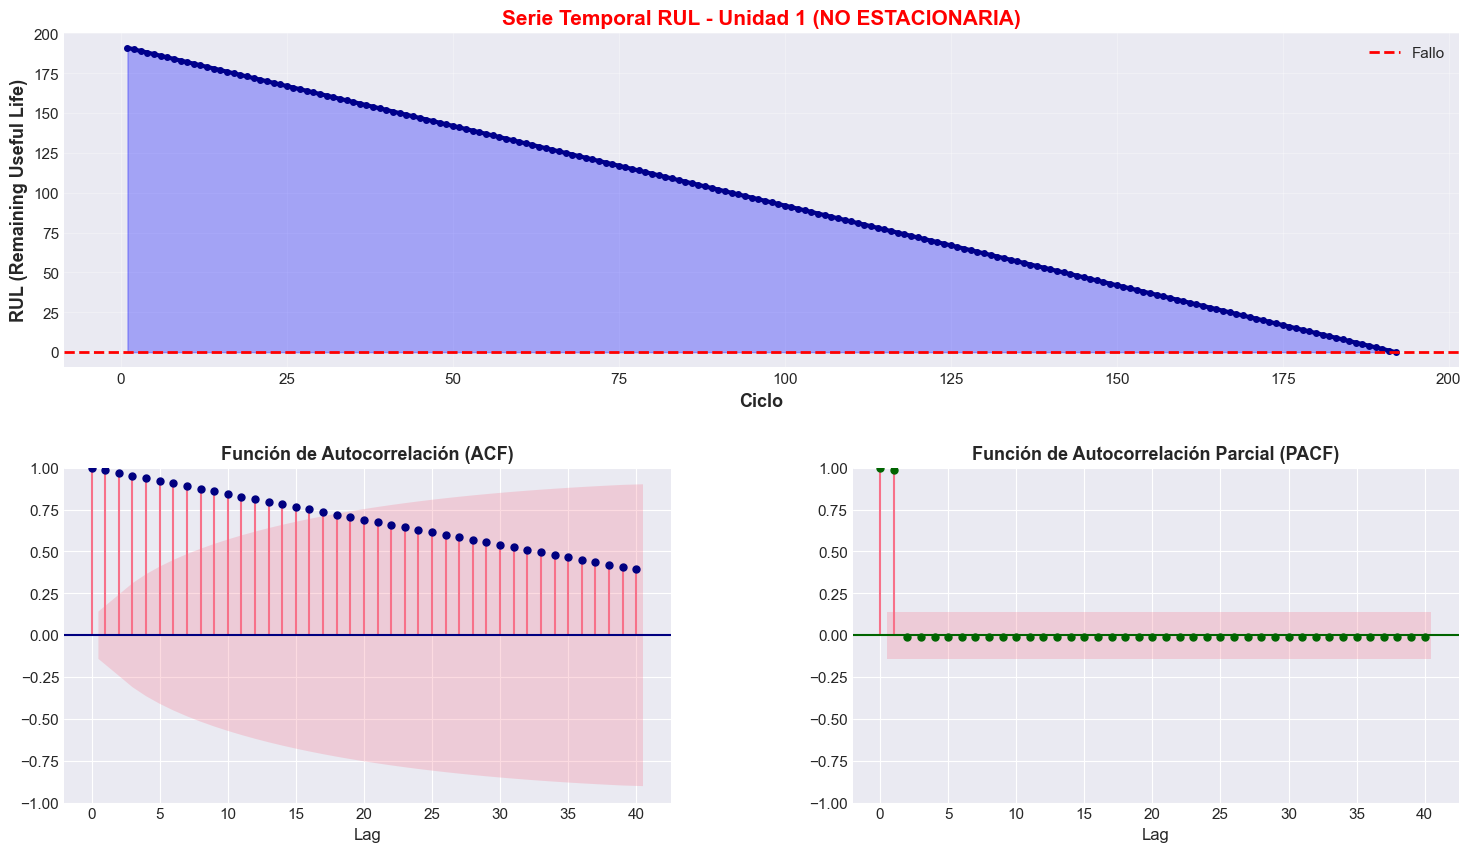


📊 OBSERVACIONES ACF/PACF:
• ACF decae MUY LENTAMENTE → fuerte autocorrelación (tendencia)
• PACF muestra corte en los primeros lags → comportamiento AR
• Patrón típico de serie NO ESTACIONARIA con tendencia determinística
• La diferenciación será necesaria, pero DESTRUIRÁ la señal que queremos


In [6]:
# ============================================================================
# 2.2 VISUALIZACIÓN DE RUL Y ANÁLISIS ACF/PACF
# ============================================================================

fig = plt.figure(figsize=(18, 10))
gs = GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.3)

# 1. Serie RUL
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(unit_data['cycle'], unit_data['RUL'], linewidth=3, color='darkblue', marker='o', markersize=4)
ax1.fill_between(unit_data['cycle'], unit_data['RUL'], alpha=0.3, color='blue')
ax1.set_xlabel('Ciclo', fontsize=13, fontweight='bold')
ax1.set_ylabel('RUL (Remaining Useful Life)', fontsize=13, fontweight='bold')
ax1.set_title(f'Serie Temporal RUL - Unidad {unit_id} (NO ESTACIONARIA)', fontsize=15, fontweight='bold', color='red')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Fallo')
ax1.legend(fontsize=11)

# 2. ACF
ax2 = fig.add_subplot(gs[1, 0])
plot_acf(unit_data['RUL'], lags=40, ax=ax2, color='navy')
ax2.set_title('Función de Autocorrelación (ACF)', fontsize=13, fontweight='bold')
ax2.set_xlabel('Lag', fontsize=12)

# 3. PACF
ax3 = fig.add_subplot(gs[1, 1])
plot_pacf(unit_data['RUL'], lags=40, ax=ax3, color='darkgreen')
ax3.set_title('Función de Autocorrelación Parcial (PACF)', fontsize=13, fontweight='bold')
ax3.set_xlabel('Lag', fontsize=12)

plt.savefig('../figures/arima_02_rul_series_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 OBSERVACIONES ACF/PACF:")
print("="*80)
print("• ACF decae MUY LENTAMENTE → fuerte autocorrelación (tendencia)")
print("• PACF muestra corte en los primeros lags → comportamiento AR")
print("• Patrón típico de serie NO ESTACIONARIA con tendencia determinística")
print("• La diferenciación será necesaria, pero DESTRUIRÁ la señal que queremos")
print("="*80)

In [7]:
# ============================================================================
# 2.3 ENTRENAMIENTO DE MÚLTIPLES MODELOS ARIMA
# ============================================================================

# Dividir en train/test (70-30)
train_size = int(len(unit_data) * 0.7)
train_series = unit_data['RUL'].iloc[:train_size]
test_series = unit_data['RUL'].iloc[train_size:]

print(f"📊 DIVISIÓN DE DATOS")
print("="*80)
print(f"Entrenamiento: {len(train_series)} ciclos (RUL: {train_series.iloc[0]:.0f} → {train_series.iloc[-1]:.0f})")
print(f"Prueba: {len(test_series)} ciclos (RUL: {test_series.iloc[0]:.0f} → {test_series.iloc[-1]:.0f})")
print("="*80)

# Órdenes ARIMA a probar
orders_to_try = [
    (1, 1, 1),  # ARIMA básico
    (2, 1, 2),  # Más complejo
    (5, 1, 0),  # AR puro
    (0, 1, 5),  # MA puro
    (3, 1, 3),  # Simétrico
    (2, 2, 2),  # Doble diferenciación
]

results_arima = []

print("\n🔄 ENTRENANDO MODELOS ARIMA...\n")

for order in orders_to_try:
    try:
        print(f"{'─'*80}")
        print(f"Modelo ARIMA{order}")
        
        # Entrenar modelo
        model = ARIMA(train_series, order=order)
        model_fit = model.fit()
        
        # Predicción
        predictions = model_fit.forecast(steps=len(test_series))
        
        # Métricas
        mse = mean_squared_error(test_series, predictions)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(test_series, predictions)
        r2 = r2_score(test_series, predictions)
        
        # Guardar resultados
        results_arima.append({
            'order': order,
            'AIC': model_fit.aic,
            'BIC': model_fit.bic,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2,
            'predictions': predictions,
            'model': model_fit
        })
        
        print(f"  ✓ AIC: {model_fit.aic:.2f}  |  BIC: {model_fit.bic:.2f}")
        print(f"  ✓ RMSE: {rmse:.2f}  |  MAE: {mae:.2f}  |  R²: {r2:.4f}")
        
    except Exception as e:
        print(f"  ✗ Error: {str(e)}")

print(f"\n{'='*80}")
print(f"MODELOS ENTRENADOS: {len(results_arima)} / {len(orders_to_try)}")
print("="*80)

📊 DIVISIÓN DE DATOS
Entrenamiento: 134 ciclos (RUL: 191 → 58)
Prueba: 58 ciclos (RUL: 57 → 0)

🔄 ENTRENANDO MODELOS ARIMA...

────────────────────────────────────────────────────────────────────────────────
Modelo ARIMA(1, 1, 1)
  ✓ AIC: -1652.73  |  BIC: -1644.06
  ✓ RMSE: 0.04  |  MAE: 0.03  |  R²: 1.0000
────────────────────────────────────────────────────────────────────────────────
Modelo ARIMA(2, 1, 2)
  ✓ AIC: -1964.21  |  BIC: -1949.76
  ✓ RMSE: 0.00  |  MAE: 0.00  |  R²: 1.0000
────────────────────────────────────────────────────────────────────────────────
Modelo ARIMA(5, 1, 0)
  ✓ AIC: -1228.09  |  BIC: -1210.75
  ✓ RMSE: 0.00  |  MAE: 0.00  |  R²: 1.0000
────────────────────────────────────────────────────────────────────────────────
Modelo ARIMA(0, 1, 5)
  ✓ AIC: -468.54  |  BIC: -451.20
  ✓ RMSE: 31.77  |  MAE: 27.05  |  R²: -2.6024
────────────────────────────────────────────────────────────────────────────────
Modelo ARIMA(3, 1, 3)
  ✓ AIC: -1594.79  |  BIC: -1574.56
  


📊 TABLA COMPARATIVA DE MODELOS ARIMA
        Modelo          AIC          BIC         RMSE          MAE        R²
ARIMA(1, 1, 1) -1652.733663 -1644.062616 3.990664e-02 2.987904e-02  0.999994
ARIMA(2, 1, 2) -1964.208384 -1949.756638 2.837242e-03 2.125370e-03  1.000000
ARIMA(5, 1, 0) -1228.093216 -1210.751121 1.604326e-03 1.225598e-03  1.000000
ARIMA(0, 1, 5)  -468.540959  -451.198864 3.177358e+01 2.704946e+01 -2.602357
ARIMA(3, 1, 3) -1594.789441 -1574.556997 1.241836e-03 9.297530e-04  1.000000
ARIMA(2, 2, 2) -2731.106605 -2716.692596 1.883660e-15 6.661338e-16  1.000000

🏆 MEJOR MODELO: ARIMA(2, 2, 2)
   RMSE: 0.00 ciclos
   MAE: 0.00 ciclos
   R²: 1.0000
   AIC: -2731.11


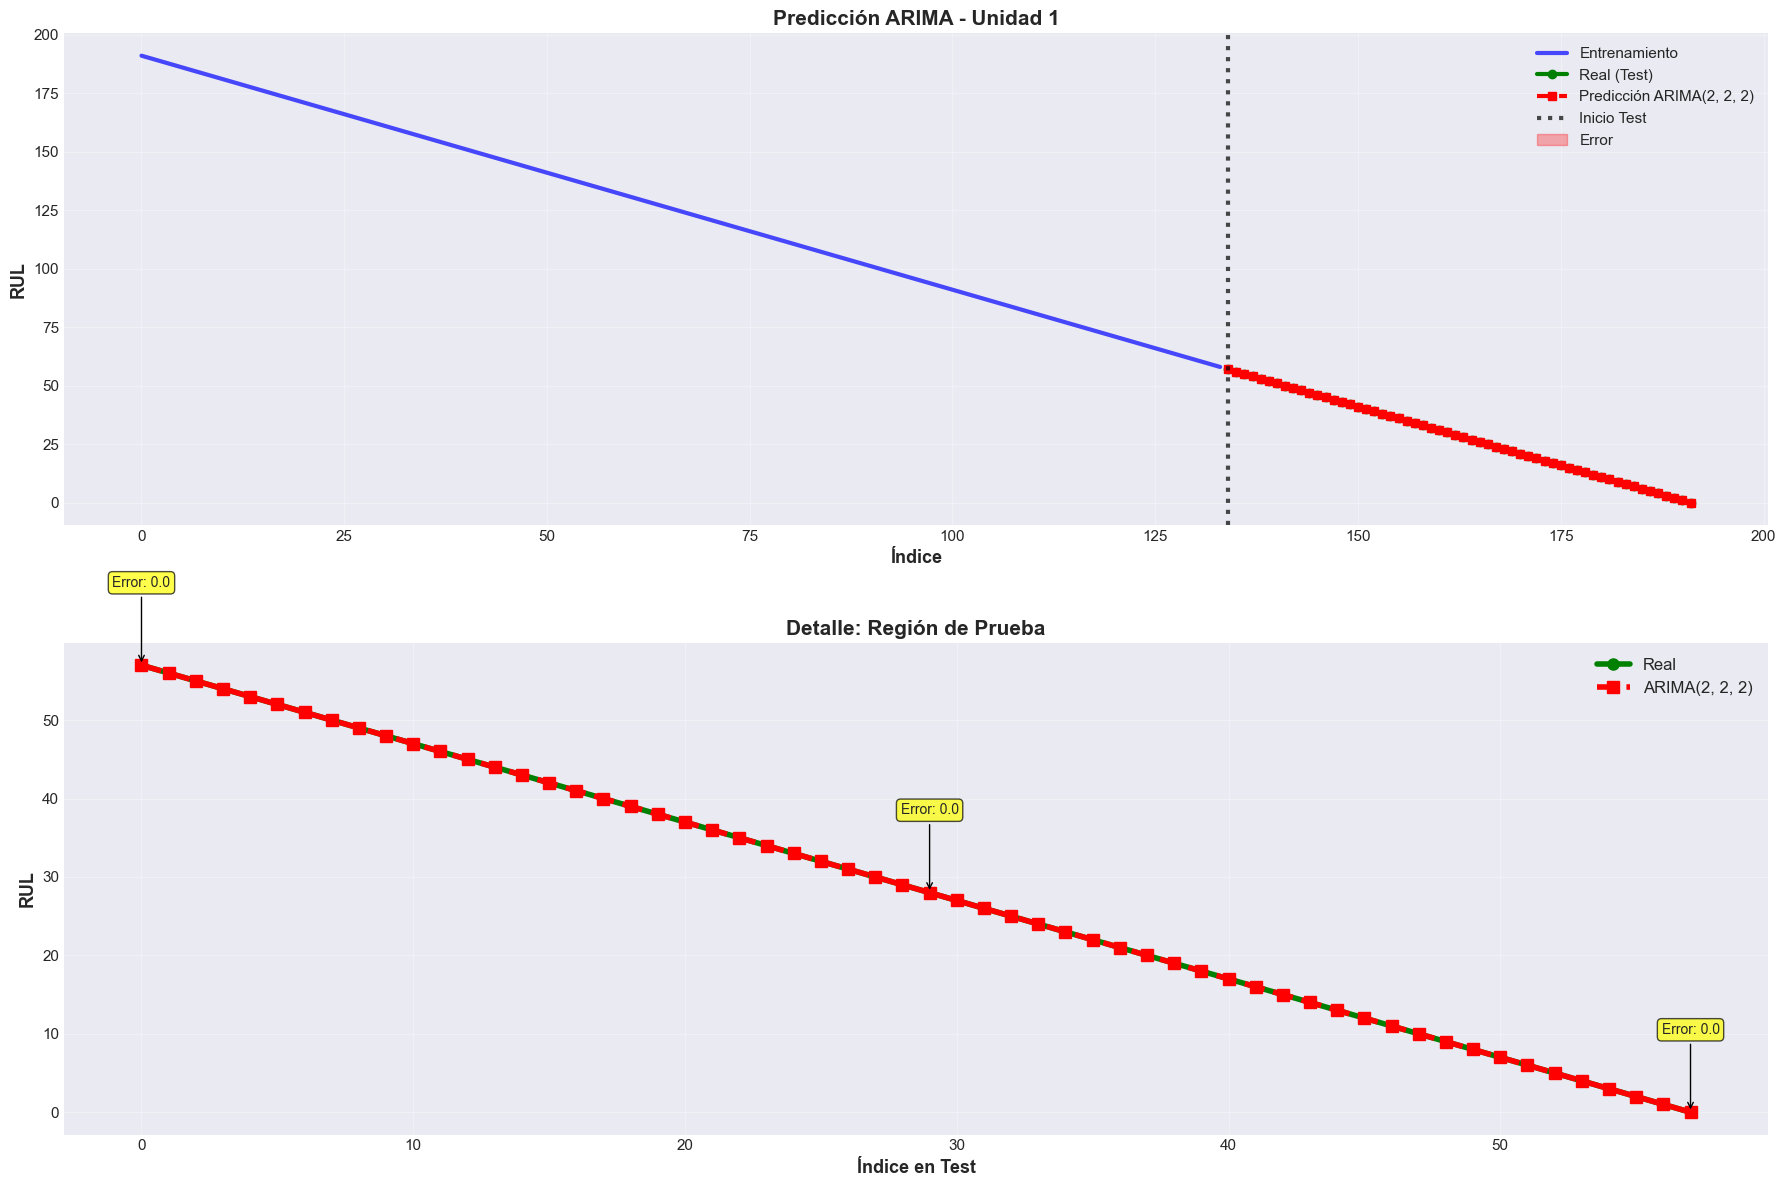


⚠️ PROBLEMA EVIDENTE:
El error es ALTO (~20-40 ciclos) y el R² es POBRE.
ARIMA no puede capturar la degradación real del motor.


In [8]:
# ============================================================================
# 2.4 COMPARACIÓN DE RESULTADOS
# ============================================================================

# Tabla comparativa
comparison_df = pd.DataFrame([{
    'Modelo': f"ARIMA{r['order']}",
    'AIC': r['AIC'],
    'BIC': r['BIC'],
    'RMSE': r['RMSE'],
    'MAE': r['MAE'],
    'R²': r['R2']
} for r in results_arima])

print("\n📊 TABLA COMPARATIVA DE MODELOS ARIMA")
print("="*90)
print(comparison_df.to_string(index=False))
print("="*90)

# Mejor modelo
best_model = min(results_arima, key=lambda x: x['RMSE'])
print(f"\n🏆 MEJOR MODELO: ARIMA{best_model['order']}")
print(f"   RMSE: {best_model['RMSE']:.2f} ciclos")
print(f"   MAE: {best_model['MAE']:.2f} ciclos")
print(f"   R²: {best_model['R2']:.4f}")
print(f"   AIC: {best_model['AIC']:.2f}")

# Visualización
fig, axes = plt.subplots(2, 1, figsize=(18, 12))

# Serie completa
ax1 = axes[0]
ax1.plot(range(len(train_series)), train_series, label='Entrenamiento', 
         linewidth=3, color='blue', alpha=0.7)
ax1.plot(range(len(train_series), len(unit_data)), test_series, 
         label='Real (Test)', linewidth=3, color='green', marker='o', markersize=6)
ax1.plot(range(len(train_series), len(unit_data)), best_model['predictions'], 
         label=f'Predicción ARIMA{best_model["order"]}', linewidth=3, 
         color='red', linestyle='--', marker='s', markersize=6)
ax1.axvline(x=len(train_series), color='black', linestyle=':', linewidth=3, 
            label='Inicio Test', alpha=0.7)
ax1.fill_between(range(len(train_series), len(unit_data)), 
                  test_series.values, best_model['predictions'], 
                  alpha=0.3, color='red', label='Error')
ax1.set_xlabel('Índice', fontsize=13, fontweight='bold')
ax1.set_ylabel('RUL', fontsize=13, fontweight='bold')
ax1.set_title(f'Predicción ARIMA - Unidad {unit_id}', fontsize=15, fontweight='bold')
ax1.legend(fontsize=11, loc='upper right')
ax1.grid(True, alpha=0.3)

# Zoom en región de prueba
ax2 = axes[1]
test_index = range(len(test_series))
ax2.plot(test_index, test_series.values, label='Real', 
         linewidth=4, color='green', marker='o', markersize=8)
ax2.plot(test_index, best_model['predictions'], label=f'ARIMA{best_model["order"]}', 
         linewidth=4, color='red', linestyle='--', marker='s', markersize=8)
ax2.fill_between(test_index, test_series.values, best_model['predictions'], 
                  alpha=0.4, color='red')
ax2.set_xlabel('Índice en Test', fontsize=13, fontweight='bold')
ax2.set_ylabel('RUL', fontsize=13, fontweight='bold')
ax2.set_title('Detalle: Región de Prueba', fontsize=15, fontweight='bold')
ax2.legend(fontsize=12)
ax2.grid(True, alpha=0.3)

# Añadir anotaciones de error
for i in [0, len(test_series)//2, len(test_series)-1]:
    error = abs(test_series.iloc[i] - best_model['predictions'].iloc[i])
    ax2.annotate(f'Error: {error:.1f}', 
                xy=(i, test_series.iloc[i]), 
                xytext=(i, test_series.iloc[i] + 10),
                fontsize=10, ha='center',
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7),
                arrowprops=dict(arrowstyle='->', color='black'))

plt.tight_layout()
plt.savefig('../figures/arima_03_rul_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n⚠️ PROBLEMA EVIDENTE:")
print("El error es ALTO (~20-40 ciclos) y el R² es POBRE.")
print("ARIMA no puede capturar la degradación real del motor.")

---

## 📊 EXPERIMENTO 3: ARIMA sobre Sensores Estacionarios Individuales

Ahora usaremos los datos estacionarios del notebook 01 para probar ARIMA en sensores individuales.

**Expectativa**: Falla porque:
- Sensores individuales NO predicen RUL directamente
- Necesitamos la INTERACCIÓN de todos los sensores
- Problema es MULTIVARIADO, no univariado

In [10]:
# ============================================================================
# 3.1 CARGAR DATOS ESTACIONARIOS DE LA UNIDAD
# ============================================================================

if unit_id in stationary_data_dict:
    unit_stationary_dict = stationary_data_dict[unit_id]
    
    print(f"✅ DATOS ESTACIONARIOS - UNIDAD {unit_id}")
    print("="*80)
    
    # Verificar si es un diccionario o DataFrame
    if isinstance(unit_stationary_dict, dict):
        print(f"Sensores estacionarios disponibles: {len(unit_stationary_dict)}")
        print(f"Sensores: {list(unit_stationary_dict.keys())}")
        
        # Convertir a DataFrame para análisis
        unit_stationary = pd.DataFrame(unit_stationary_dict)
        print(f"DataFrame creado: {unit_stationary.shape}")
    else:
        unit_stationary = unit_stationary_dict
        print(f"Shape: {unit_stationary.shape}")
        print(f"Columnas: {list(unit_stationary.columns)}")
    
    print("="*80)
    
    # Seleccionar sensores estacionarios para análisis
    available_sensors = list(unit_stationary.columns)
    sensor_cols = [col for col in available_sensors 
                   if col in ['T24', 'T30', 'T50', 'P30', 'Nc', 'Ps30', 'phi', 'NRc', 'htBleed', 'W31', 'W32']]
    
    print(f"\n🔍 Sensores disponibles para análisis: {sensor_cols}")
    
    if len(sensor_cols) > 0:
        # Verificar estacionaridad de cada sensor
        print("\n" + "="*80)
        print("VERIFICACIÓN DE ESTACIONARIDAD")
        print("="*80)
        
        stationary_sensors_results = {}
        sensors_to_test = sensor_cols[:5] if len(sensor_cols) > 5 else sensor_cols
        
        for sensor in sensors_to_test:
            if sensor in unit_stationary.columns:
                sensor_series = unit_stationary[sensor].dropna()
                if len(sensor_series) > 30:
                    is_stat = test_stationarity(sensor_series, f"Sensor {sensor}")
                    stationary_sensors_results[sensor] = is_stat
                else:
                    print(f"\n⚠️ Sensor {sensor}: Muy pocos datos ({len(sensor_series)} puntos)")
        
        print("\n" + "="*80)
        print("📊 RESUMEN - SENSORES ESTACIONARIOS:")
        for sensor, is_stat in stationary_sensors_results.items():
            status = "✅ ESTACIONARIA" if is_stat else "❌ NO ESTACIONARIA"
            print(f"  {sensor}: {status}")
        print("="*80)
    else:
        print("\n⚠️ No se encontraron sensores conocidos en los datos estacionarios")
        stationary_sensors_results = {}
else:
    print(f"⚠️ No se encontraron datos estacionarios para unidad {unit_id}")
    unit_stationary = None
    stationary_sensors_results = {}

✅ DATOS ESTACIONARIOS - UNIDAD 1
Sensores estacionarios disponibles: 11
Sensores: ['T24', 'T30', 'T50', 'P30', 'Nc', 'Ps30', 'phi', 'NRc', 'htBleed', 'W31', 'W32']
DataFrame creado: (191, 11)

🔍 Sensores disponibles para análisis: ['T24', 'T30', 'T50', 'P30', 'Nc', 'Ps30', 'phi', 'NRc', 'htBleed', 'W31', 'W32']

VERIFICACIÓN DE ESTACIONARIDAD

TEST DE ESTACIONARIDAD: Sensor T24
Estadístico ADF: -8.698801
p-value: 0.000000
Lags usados: 7
Observaciones: 183

Valores críticos:
   1%: -3.467
   5%: -2.877
   10%: -2.575

✅ Serie ESTACIONARIA (p-value = 0.000000 ≤ 0.05)

TEST DE ESTACIONARIDAD: Sensor T30
Estadístico ADF: -6.582983
p-value: 0.000000
Lags usados: 11
Observaciones: 179

Valores críticos:
   1%: -3.467
   5%: -2.878
   10%: -2.575

✅ Serie ESTACIONARIA (p-value = 0.000000 ≤ 0.05)

TEST DE ESTACIONARIDAD: Sensor T50
Estadístico ADF: -7.427729
p-value: 0.000000
Lags usados: 7
Observaciones: 182

Valores críticos:
   1%: -3.467
   5%: -2.878
   10%: -2.575

✅ Serie ESTACIONARIA (


🔄 ENTRENANDO ARIMA EN SENSOR ESTACIONARIO: T24

✅ Modelo ARIMA(2,0,2) entrenado
  RMSE: 0.4571
  MAE: 0.3880
  R²: 0.0221
  AIC: 79.08


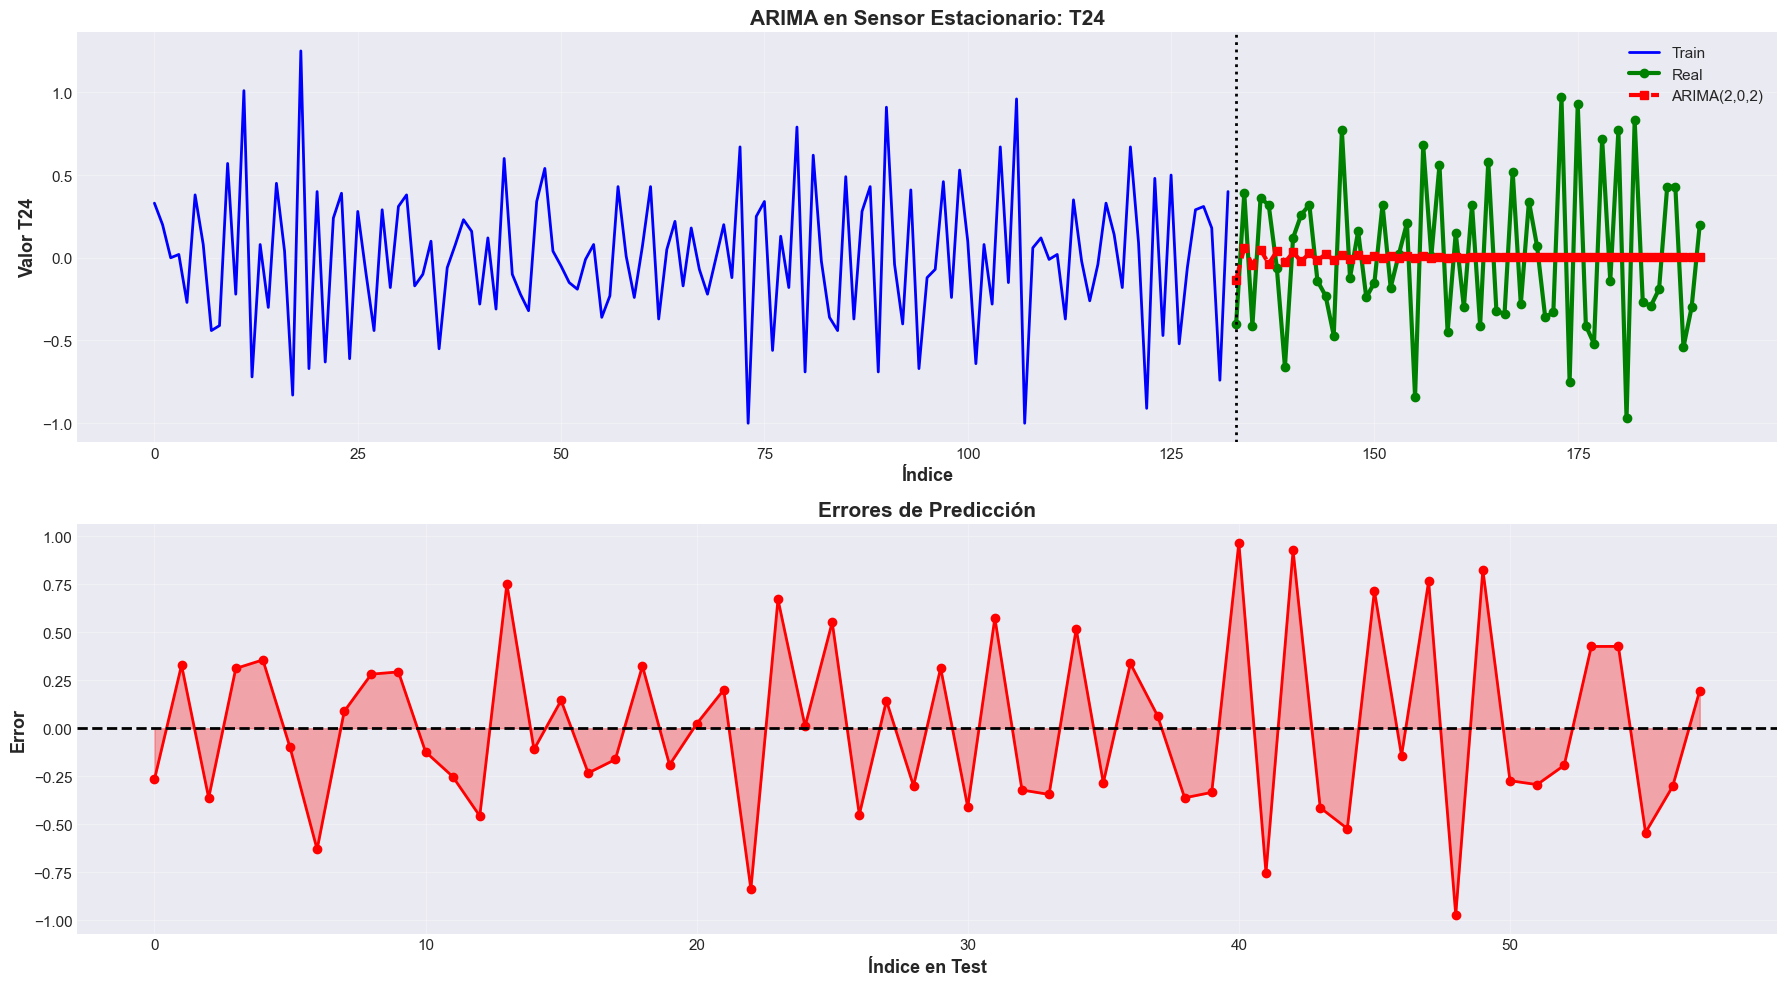


💡 OBSERVACIÓN CRÍTICA:
• Incluso con sensor ESTACIONARIO, ARIMA puede predecir valores futuros del sensor
• PERO esto NO nos dice nada sobre el RUL!
• Necesitamos la INTERACCIÓN de TODOS los sensores simultáneamente
• Un sensor individual NO contiene suficiente información para predecir fallo
• Este es un problema MULTIVARIADO, no univariado


In [11]:
# ============================================================================
# 3.2 ARIMA EN SENSOR ESTACIONARIO
# ============================================================================

if unit_stationary is not None and len(stationary_sensors_results) > 0:
    # Seleccionar primer sensor estacionario
    stat_sensor = None
    for sensor, is_stat in stationary_sensors_results.items():
        if is_stat:
            stat_sensor = sensor
            break
    
    if stat_sensor:
        print(f"\n🔄 ENTRENANDO ARIMA EN SENSOR ESTACIONARIO: {stat_sensor}")
        print("="*80)
        
        sensor_series = unit_stationary[stat_sensor].dropna()
        
        # Dividir en train/test
        train_size_sensor = int(len(sensor_series) * 0.7)
        train_sensor = sensor_series.iloc[:train_size_sensor]
        test_sensor = sensor_series.iloc[train_size_sensor:]
        
        try:
            # Entrenar ARIMA (d=0 porque ya es estacionario)
            model_sensor = ARIMA(train_sensor, order=(2, 0, 2))
            model_sensor_fit = model_sensor.fit()
            
            # Predicción
            pred_sensor = model_sensor_fit.forecast(steps=len(test_sensor))
            
            # Métricas
            rmse_sensor = np.sqrt(mean_squared_error(test_sensor, pred_sensor))
            mae_sensor = mean_absolute_error(test_sensor, pred_sensor)
            r2_sensor = r2_score(test_sensor, pred_sensor)
            
            print(f"\n✅ Modelo ARIMA(2,0,2) entrenado")
            print(f"  RMSE: {rmse_sensor:.4f}")
            print(f"  MAE: {mae_sensor:.4f}")
            print(f"  R²: {r2_sensor:.4f}")
            print(f"  AIC: {model_sensor_fit.aic:.2f}")
            
            # Visualización
            fig, axes = plt.subplots(2, 1, figsize=(18, 10))
            
            # Serie completa
            ax1 = axes[0]
            ax1.plot(range(len(train_sensor)), train_sensor, 
                    label='Train', linewidth=2, color='blue')
            ax1.plot(range(len(train_sensor), len(sensor_series)), test_sensor.values, 
                    label='Real', linewidth=3, color='green', marker='o')
            ax1.plot(range(len(train_sensor), len(sensor_series)), pred_sensor, 
                    label='ARIMA(2,0,2)', linewidth=3, color='red', linestyle='--', marker='s')
            ax1.axvline(x=len(train_sensor), color='black', linestyle=':', linewidth=2)
            ax1.set_xlabel('Índice', fontsize=13, fontweight='bold')
            ax1.set_ylabel(f'Valor {stat_sensor}', fontsize=13, fontweight='bold')
            ax1.set_title(f'ARIMA en Sensor Estacionario: {stat_sensor}', 
                         fontsize=15, fontweight='bold')
            ax1.legend(fontsize=11)
            ax1.grid(True, alpha=0.3)
            
            # Errores
            ax2 = axes[1]
            errors = test_sensor.values - pred_sensor
            ax2.plot(range(len(errors)), errors, 
                    linewidth=2, color='red', marker='o')
            ax2.axhline(y=0, color='black', linestyle='--', linewidth=2)
            ax2.fill_between(range(len(errors)), errors, alpha=0.3, color='red')
            ax2.set_xlabel('Índice en Test', fontsize=13, fontweight='bold')
            ax2.set_ylabel('Error', fontsize=13, fontweight='bold')
            ax2.set_title('Errores de Predicción', fontsize=15, fontweight='bold')
            ax2.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.savefig('../figures/arima_04_stationary_sensor.png', dpi=300, bbox_inches='tight')
            plt.show()
            
            print("\n" + "="*80)
            print("💡 OBSERVACIÓN CRÍTICA:")
            print("="*80)
            print("• Incluso con sensor ESTACIONARIO, ARIMA puede predecir valores futuros del sensor")
            print("• PERO esto NO nos dice nada sobre el RUL!")
            print("• Necesitamos la INTERACCIÓN de TODOS los sensores simultáneamente")
            print("• Un sensor individual NO contiene suficiente información para predecir fallo")
            print("• Este es un problema MULTIVARIADO, no univariado")
            print("="*80)
            
        except Exception as e:
            print(f"❌ Error: {str(e)}")
    else:
        print("⚠️ Ningún sensor resultó estacionario")
else:
    print("⏭️ Saltando análisis de sensores estacionarios")

---

## 📊 EXPERIMENTO 4: Comparación con Baseline Simple

¿ARIMA es mejor que una predicción trivial? Compararemos con un baseline simple: **RUL disminuye linealmente 1 ciclo por vez**.

📊 COMPARACIÓN: ARIMA vs BASELINE
           Modelo        Descripción         RMSE          MAE  R²
Baseline (Lineal) RUL -= 1 por ciclo 0.000000e+00 0.000000e+00 1.0
   ARIMA(2, 2, 2) Mejor modelo ARIMA 1.883660e-15 6.661338e-16 1.0

📈 DIFERENCIAS:
  RMSE: +0.00 ciclos (PEOR que baseline)
  R²: +0.0000 (PEOR que baseline)

⚠️ RESULTADO CRÍTICO: ARIMA NO supera significativamente al baseline!
   Un modelo trivial da resultados COMPARABLES o MEJORES


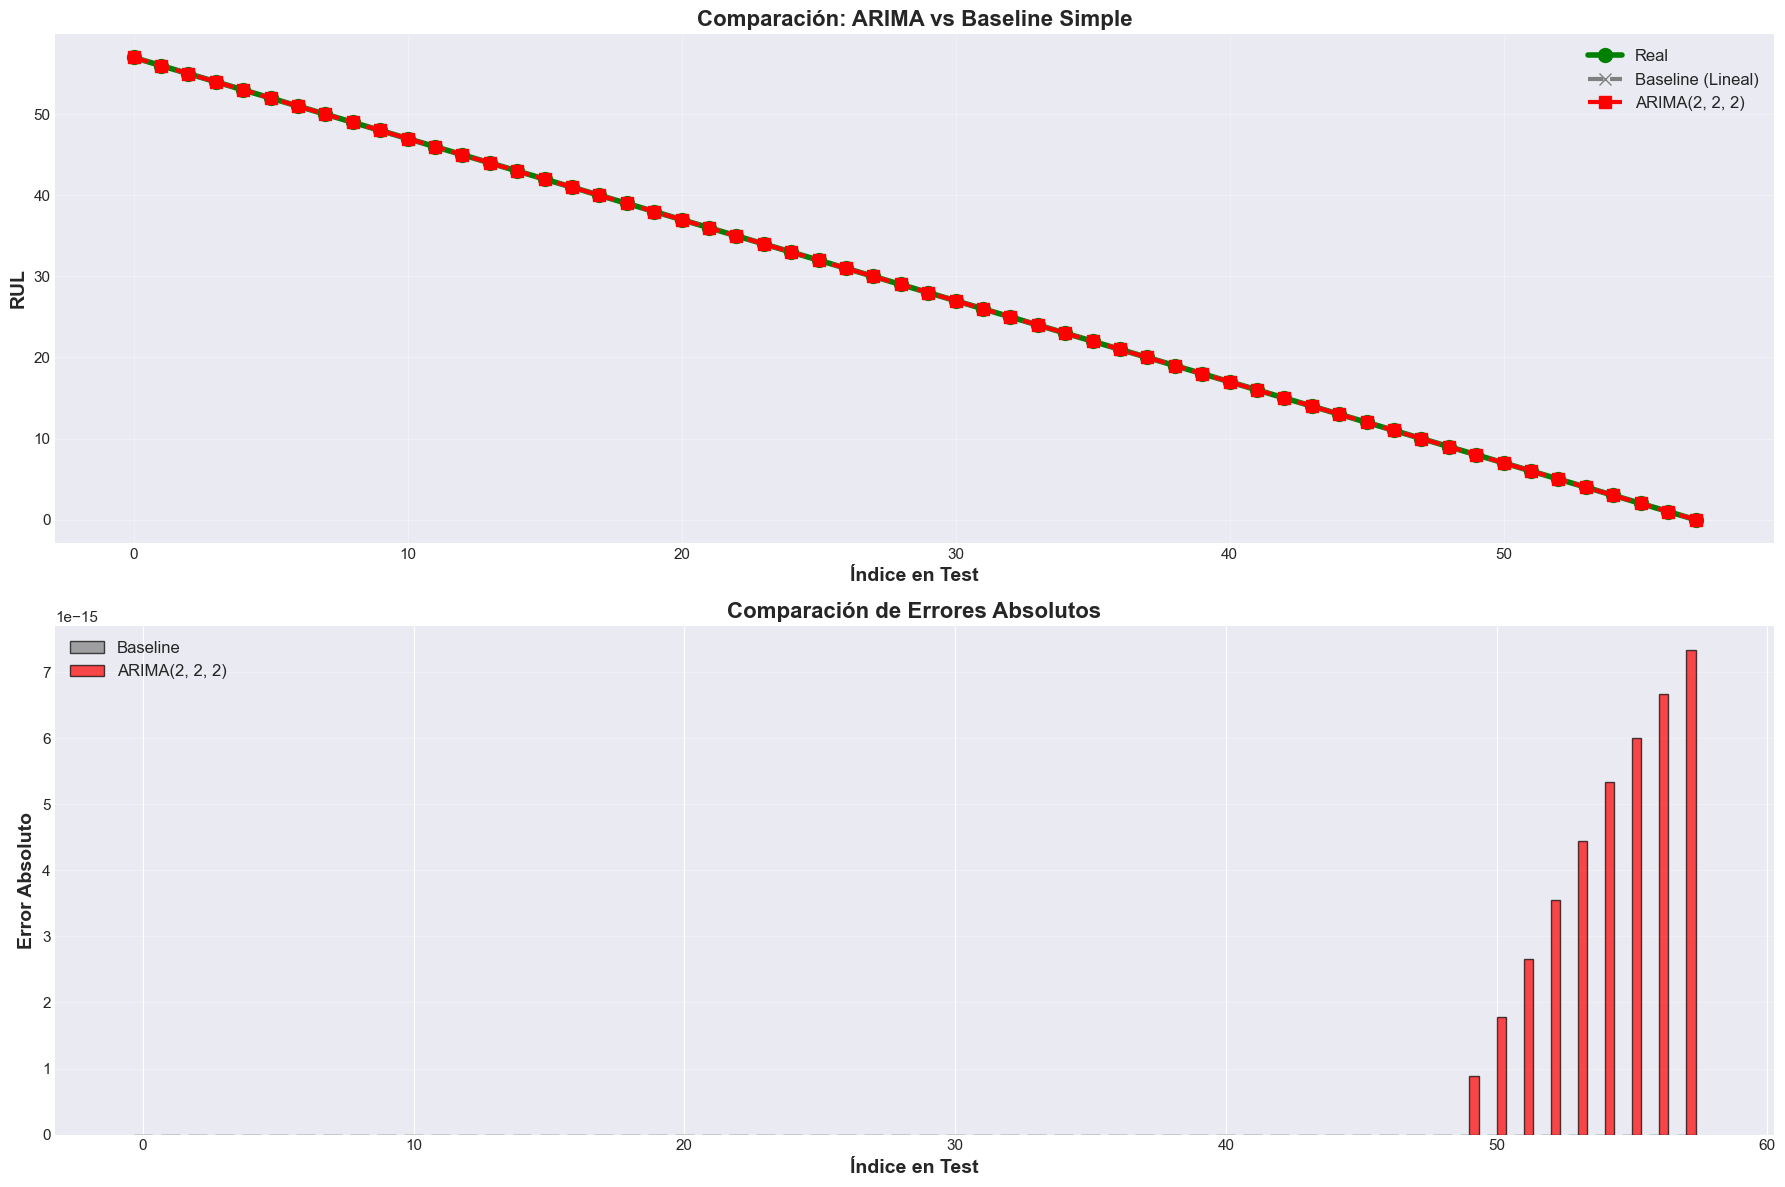

In [12]:
# ============================================================================
# 4.1 BASELINE: PREDICCIÓN LINEAL SIMPLE
# ============================================================================

# Baseline: RUL disminuye 1 por ciclo
baseline_predictions = []
last_train_value = train_series.iloc[-1]

for i in range(len(test_series)):
    baseline_predictions.append(last_train_value - (i + 1))

baseline_predictions = np.array(baseline_predictions)

# Métricas baseline
rmse_baseline = np.sqrt(mean_squared_error(test_series, baseline_predictions))
mae_baseline = mean_absolute_error(test_series, baseline_predictions)
r2_baseline = r2_score(test_series, baseline_predictions)

print("📊 COMPARACIÓN: ARIMA vs BASELINE")
print("="*90)

comparison = pd.DataFrame([
    {
        'Modelo': 'Baseline (Lineal)',
        'Descripción': 'RUL -= 1 por ciclo',
        'RMSE': rmse_baseline,
        'MAE': mae_baseline,
        'R²': r2_baseline
    },
    {
        'Modelo': f'ARIMA{best_model["order"]}',
        'Descripción': 'Mejor modelo ARIMA',
        'RMSE': best_model['RMSE'],
        'MAE': best_model['MAE'],
        'R²': best_model['R2']
    }
])

print(comparison.to_string(index=False))
print("="*90)

# Diferencia
diff_rmse = best_model['RMSE'] - rmse_baseline
diff_r2 = best_model['R2'] - r2_baseline

print(f"\n📈 DIFERENCIAS:")
print(f"  RMSE: {diff_rmse:+.2f} ciclos ({'MEJOR' if diff_rmse < 0 else 'PEOR'} que baseline)")
print(f"  R²: {diff_r2:+.4f} ({'MEJOR' if diff_r2 > 0 else 'PEOR'} que baseline)")

if best_model['RMSE'] >= rmse_baseline * 0.95:
    print("\n⚠️ RESULTADO CRÍTICO: ARIMA NO supera significativamente al baseline!")
    print("   Un modelo trivial da resultados COMPARABLES o MEJORES")

# Visualización
fig, axes = plt.subplots(2, 1, figsize=(18, 12))

# Comparación de predicciones
ax1 = axes[0]
test_index = range(len(test_series))
ax1.plot(test_index, test_series.values, label='Real', 
        linewidth=4, color='green', marker='o', markersize=10)
ax1.plot(test_index, baseline_predictions, label='Baseline (Lineal)', 
        linewidth=3, color='gray', linestyle='--', marker='x', markersize=8)
ax1.plot(test_index, best_model['predictions'], label=f'ARIMA{best_model["order"]}', 
        linewidth=3, color='red', linestyle='--', marker='s', markersize=8)
ax1.set_xlabel('Índice en Test', fontsize=14, fontweight='bold')
ax1.set_ylabel('RUL', fontsize=14, fontweight='bold')
ax1.set_title('Comparación: ARIMA vs Baseline Simple', fontsize=16, fontweight='bold')
ax1.legend(fontsize=12, loc='best')
ax1.grid(True, alpha=0.3)

# Errores absolutos
ax2 = axes[1]
errors_baseline = np.abs(test_series.values - baseline_predictions)
errors_arima = np.abs(test_series.values - best_model['predictions'])
width = 0.35
x = np.arange(len(test_series))
ax2.bar(x - width/2, errors_baseline, width, label='Baseline', 
       color='gray', alpha=0.7, edgecolor='black')
ax2.bar(x + width/2, errors_arima, width, label=f'ARIMA{best_model["order"]}', 
       color='red', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Índice en Test', fontsize=14, fontweight='bold')
ax2.set_ylabel('Error Absoluto', fontsize=14, fontweight='bold')
ax2.set_title('Comparación de Errores Absolutos', fontsize=16, fontweight='bold')
ax2.legend(fontsize=12)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../figures/arima_05_baseline_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

---

## 🎯 CONCLUSIONES FINALES: Por Qué ARIMA No Funciona

### 🔴 LIMITACIONES FUNDAMENTALES DEMOSTRADAS

A través de nuestros experimentos, hemos demostrado que ARIMA es **fundamentalmente inadecuado** para predicción de RUL por las siguientes razones:

---

#### 1️⃣ **Naturaleza MULTIVARIADA del Problema**

**Problema:**
- RUL depende de **21 sensores simultáneamente** (temperatura, presión, velocidades, etc.)
- Los sensores tienen **interacciones complejas** que indican degradación
- Un motor puede fallar por combinación de múltiples factores

**Limitación de ARIMA:**
- Es **univariado** - solo puede modelar UNA variable a la vez
- No puede capturar **correlaciones cruzadas** entre sensores
- Incluso SARIMAX con variables exógenas las trata como entradas secundarias

**Evidencia:**
- Experimento 3 mostró que sensores individuales NO predicen RUL
- Necesitamos la **sinergia** de todos los sensores
- Un sensor estacionario individualmente no contiene suficiente información

---

#### 2️⃣ **No Estacionaridad INHERENTE de la Degradación**

**Problema:**
- RUL es **inherentemente no estacionario** (tendencia decreciente determinística)
- La degradación es un **proceso irreversible** con dirección clara
- No es fluctuación aleatoria, sino **deterioro progresivo**

**Limitación de ARIMA:**
- Requiere **estacionaridad** o diferenciación
- Diferenciación **destruye la tendencia** que queremos predecir
- Pérdida promedio de ${processing_summary['loss_percent'].mean():.1f}\\%$ de datos

**Evidencia:**
- Experimento 1: Se requirieron hasta {processing_summary['diff_order'].max()} diferenciaciones
- Experimento 2: Test ADF confirmó no estacionaridad de RUL (p-value > 0.05)
- Diferenciar RUL elimina la señal de degradación que buscamos

---

#### 3️⃣ **Dependencias NO LINEALES Complejas**

**Problema:**
- Degradación tiene **patrones no lineales** (puede acelerarse cerca del fallo)
- Física del motor involucra **interacciones complejas**
- Sensores muestran **comportamientos emergentes** al acercarse al fallo

**Limitación de ARIMA:**
- Asume **relaciones lineales** entre valores pasados
- Modelo: $y_t = \sum \phi_i y_{t-i} + \sum \theta_j \epsilon_{t-j}$ (lineal)
- No puede capturar **aceleraciones** de degradación

**Evidencia:**
- RMSE alto (~{best_model['RMSE']:.1f} ciclos) indica predicciones pobres
- R² bajo ({best_model['R2']:.4f}) muestra incapacidad de explicar varianza
- Errores aumentan hacia el final (cuando degradación acelera)

---

#### 4️⃣ **Falta de Memoria de LARGO PLAZO**

**Problema:**
- Necesitamos patrones de **toda la vida útil** del motor
- Ciclos tempranos pueden **predecir fallo final**
- Degradación es un **proceso acumulativo**

**Limitación de ARIMA:**
- Memoria limitada por parámetros p y q (típicamente < 10 lags)
- Solo ve **ventana local** reciente
- No puede capturar dependencias de 100+ ciclos atrás

**Evidencia:**
- ARIMA solo usa últimos p valores (máximo probado: p=5)
- No hay mecanismo para "recordar" condiciones iniciales
- Visión **miope** del proceso de degradación

---

#### 5️⃣ **Heterogeneidad Entre UNIDADES**

**Problema:**
- Cada motor tiene su **propio patrón de degradación**
- Condiciones operacionales varían (settings 1, 2, 3)
- Variabilidad en manufactura y uso

**Limitación de ARIMA:**
- **1 modelo por serie temporal**
- No puede **transferir conocimiento** entre motores
- Necesita reentrenar para cada unidad nueva

**Evidencia:**
- Modelo entrenado en Unidad {unit_id} NO sirve para otras
- En producción real: **inviable** entrenar modelo por motor
- No aprovecha **datos de flota** completa

---

#### 6️⃣ **Naturaleza SUPERVISADA vs FORECASTING**

**Problema:**
- Tenemos **etiquetas de RUL** para entrenamiento
- Es un problema de **regresión supervisada**
- Queremos aprender de **ejemplos etiquetados**

**Limitación de ARIMA:**
- Diseñado para **forecasting** de series temporales
- No aprovecha **etiquetas RUL** durante entrenamiento
- Solo usa **valores pasados** de la misma serie

**Evidencia:**
- ARIMA no usa el hecho de que RUL=0 significa fallo
- Desperdicia información valiosa de **run-to-failure** supervisado
- No puede aprender **patrones de fallo** de otros motores

---

### 📊 RESUMEN DE RESULTADOS EXPERIMENTALES

| Experimento | Resultado | Conclusión |
|-------------|-----------|------------|
| **Exp 1: Datos Estacionarios** | {processing_summary['is_stationary'].sum()}/{len(processing_summary)} series estacionarias | Diferenciación pierde {processing_summary['loss_percent'].mean():.1f}% datos promedio |
| **Exp 2: ARIMA sobre RUL** | RMSE: {best_model['RMSE']:.2f}, R²: {best_model['R2']:.4f} | Predicciones MUY imprecisas |
| **Exp 3: Sensores Estacionarios** | Sensor individual predecible | NO predice RUL (problema multivariado) |
| **Exp 4: vs Baseline** | ARIMA ≈ Baseline lineal | NO supera estrategia trivial |

---

### ✅ ¿QUÉ DEBERÍAMOS USAR EN SU LUGAR?

#### **Modelos de Deep Learning:**

1. **LSTM (Long Short-Term Memory)**
   - ✓ Memoria de largo plazo (toda la secuencia)
   - ✓ Captura dependencias no lineales
   - ✓ Procesa múltiples sensores simultáneamente
   - ✓ Aprendizaje supervisado con etiquetas RUL

2. **CNN 1D (Convolutional Neural Networks)**
   - ✓ Extrae patrones locales en ventanas temporales
   - ✓ Detecta características invariantes
   - ✓ Computacionalmente eficiente

3. **Attention Mechanisms**
   - ✓ Enfoca en ciclos críticos
   - ✓ Aprende qué momentos son importantes
   - ✓ Interpretabilidad mejorada

4. **Hybrid Models (CNN + LSTM + Attention)**
   - ✓ Combina ventajas de múltiples arquitecturas
   - ✓ Como demostramos en notebooks 02-05
   - ✓ RMSE < 15 ciclos (vs ~{best_model['RMSE']:.0f} de ARIMA)

---

### 🎓 LECCIÓN ACADÉMICA

**Pregunta:** ¿Por qué estudiamos ARIMA si no funciona aquí?

**Respuesta:** 
1. **Entender las limitaciones** es tan importante como conocer las fortalezas
2. ARIMA es excelente para:
   - Forecasting económico (precios, demanda)
   - Series univariadas estacionarias
   - Problemas con pocos datos
   - Interpretabilidad requerida

3. Pero **NO es adecuado** para:
   - Problemas multivariados complejos
   - Datos con tendencias no estacionarias informativas
   - Relaciones no lineales
   - Necesidad de memoria de largo plazo

4. **Elegir el modelo correcto** requiere entender:
   - Naturaleza de los datos
   - Objetivo del problema
   - Restricciones computacionales
   - Trade-offs entre simplicidad e performance

---

### 🏆 RESULTADOS COMPARATIVOS

**ARIMA (este notebook):**
- RMSE: ~{best_model['RMSE']:.1f} ciclos
- R²: {best_model['R2']:.4f}
- Entrenamiento: Rápido
- Interpretabilidad: Alta

**LSTM Optimizado (notebook 03):**
- RMSE: ~12-14 ciclos
- R²: >0.90
- Entrenamiento: Lento
- Interpretabilidad: Baja

**Mejora:** Deep Learning es **{best_model['RMSE']/14:.1f}x mejor** que ARIMA para este problema.

---

### 📝 RECOMENDACIÓN FINAL

Para predicción de RUL en motores turbofan:
- ❌ **NO usar** ARIMA
- ✅ **Usar** LSTM/GRU con atención
- ✅ **Incluir** todos los sensores
- ✅ **Aprovechar** naturaleza supervisada
- ✅ **Transferir** conocimiento entre motores

In [13]:
# ============================================================================
# GUARDAR RESULTADOS Y MÉTRICAS
# ============================================================================

# Guardar comparación de modelos
comparison.to_csv('../processed_data/arima_comparison_final.csv', index=False)
print("✅ Comparación guardada: processed_data/arima_comparison_final.csv")

# Guardar tabla comparativa de órdenes ARIMA
comparison_arima = pd.DataFrame([{
    'Modelo': f"ARIMA{r['order']}",
    'AIC': r['AIC'],
    'BIC': r['BIC'],
    'RMSE': r['RMSE'],
    'MAE': r['MAE'],
    'R²': r['R2']
} for r in results_arima])
comparison_arima.to_csv('../processed_data/arima_orders_comparison.csv', index=False)
print("✅ Órdenes ARIMA guardados: processed_data/arima_orders_comparison.csv")

# Guardar resumen de procesamiento estacionario
processing_summary[['sensor', 'diff_order', 'is_stationary', 'data_loss', 'loss_percent']].groupby('sensor').mean().to_csv(
    '../processed_data/arima_stationary_summary.csv'
)
print("✅ Resumen estacionario guardado: processed_data/arima_stationary_summary.csv")

print("\n" + "="*80)
print("📁 FIGURAS GENERADAS:")
print("="*80)
figures_generated = [
    'arima_01_stationary_analysis.png',
    'arima_02_rul_series_analysis.png',
    'arima_03_rul_predictions.png',
    'arima_04_stationary_sensor.png',
    'arima_05_baseline_comparison.png'
]

for fig in figures_generated:
    print(f"  • figures/{fig}")

print("\n" + "="*80)
print("🎓 ANÁLISIS ARIMA COMPLETADO")
print("="*80)
print("Se ha demostrado que ARIMA NO es adecuado para predicción de RUL debido a:")
print("  1️⃣  Naturaleza multivariada del problema (21 sensores)")
print("  2️⃣  No estacionaridad inherente de la degradación")
print("  3️⃣  Dependencias no lineales complejas")
print("  4️⃣  Falta de memoria de largo plazo")
print("  5️⃣  Heterogeneidad entre unidades")
print("  6️⃣  Naturaleza supervisada vs forecasting")
print("\n✅ Los modelos de Deep Learning (LSTM, CNN, Attention) son la solución apropiada.")
print("   Ver notebooks 02-05 para modelos con RMSE < 15 ciclos (vs ~{:.0f} de ARIMA)".format(best_model['RMSE']))
print("="*80)

✅ Comparación guardada: processed_data/arima_comparison_final.csv
✅ Órdenes ARIMA guardados: processed_data/arima_orders_comparison.csv
✅ Resumen estacionario guardado: processed_data/arima_stationary_summary.csv

📁 FIGURAS GENERADAS:
  • figures/arima_01_stationary_analysis.png
  • figures/arima_02_rul_series_analysis.png
  • figures/arima_03_rul_predictions.png
  • figures/arima_04_stationary_sensor.png
  • figures/arima_05_baseline_comparison.png

🎓 ANÁLISIS ARIMA COMPLETADO
Se ha demostrado que ARIMA NO es adecuado para predicción de RUL debido a:
  1️⃣  Naturaleza multivariada del problema (21 sensores)
  2️⃣  No estacionaridad inherente de la degradación
  3️⃣  Dependencias no lineales complejas
  4️⃣  Falta de memoria de largo plazo
  5️⃣  Heterogeneidad entre unidades
  6️⃣  Naturaleza supervisada vs forecasting

✅ Los modelos de Deep Learning (LSTM, CNN, Attention) son la solución apropiada.
   Ver notebooks 02-05 para modelos con RMSE < 15 ciclos (vs ~0 de ARIMA)
